# Quick KDF/Integration with Kelly Betting POC.

## Problem Statement
Given my 1d strategy determiners, these do not adjust bet sizing at all. I simply wish to add a "bet size" field to each distribution depending on the next unit time's distribution. The kelly bet of the next unit time's distribution will be used deterministically as the bet size for the next unit time.


#### Is the problem solved?
No. Currently the Kelly Box does not seem to be working as expected for the 'g1' state.

## Results:
1. Continuous Kelly Betting on a fitted PDF to historical data (using KDE) outputs an empirically incorrect Kelly bet (assuming the Kelly box is correct). Testing discrete Kelly Bets, the optimal amount to bet is ~400% current wealth. The fitted PDF outputs 49% of current wealth. This is an extremely important point.
2. The fitting algorithm used in KDE matters quite a lot. Mostly, it matters in the selection of variance one chooses. I believe also that given (1), there is potential for the choice of algorithm to not reward/punish outliers enough in the data. Have not dug into this point deeply enough just yet.
3. Kelly box seems to still not work as expected for some of the states. For g2 & g3, we are getting larger results, which is expected as these states have generally only positive return. However, g1 always outputs the initial guess (at least for initial guesses of 0 & 0.2). This is an unsolved problem currently.

## Results Analysis
1. There are only a few reasons why this can occur. (A) The fitted PDF does not accurately represent market returns. (B) The Kelly implementation or derivation is incorrect. (C) Still need to follow up on: Picking directly from the fitted distribution and testing Kelly bet on this. Likely this should win out the vast majority of simulations if the Kelly implementation is correct.
i. If (A) is correct this is likely due to underestimating the probability of outliers. Though I'm not sure exactly how the probability would be vastly underestimated since KDE generally weights probabilities highly in line with the empirical data.
2. Placeholder
3. The Kelly box has been tested previously with simple distributions & has outputted expected Kelly bet with these known distributions (after doing the problem by hand & running it through this). The Kelly box was previously believed to be bugged wrt the integration function. However, as the integration bounds became tighter, the integration function seemed to have much more accurate results, which of course makes sense. I will continue to play with the bounds of integration & experiment around to see if there is any underlying problem with the implementation itself.

In [78]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import gaussian_kde
import statsmodels.api as sm
import matplotlib.pyplot as plt
from Driver.driver import compute_alpha_with_markov_strat_for_ticker, retrieve_and_add_markov, compute_alpha_with_markov_strat_for_list_tickers, retrieve_data_and_add_features, assign_states_and_calculate_transition_probabilities, generate_report_files
from Scrapers.yf_scraper import YFScraper
from Markov_State_Determiners.Czech_State_Determiner import CzechStateDeterminer
from Transition_Probability_Calculation.Empirical_Calculator import EmpiricalCalculator
from Markov_Strategies.Czech_State_Determiner.Czech_Strategy1 import CzechStrategy1
from Markov_Strategies.Czech_State_Determiner.Geometric_Mean_Optimal_Strategy import Geometric_Mean_Optimal_Strategy

In [79]:
# BM: NOTEBOOK PARAMETERS.
ticker = 'SPY'
start='2010-01-01'
end='2024-01-01'

In [80]:
# BM: State Assignment
def filter_data_by_state(data):
    filtered_data = {}
    for possible_state in data['state'].unique():
        filtered_data[possible_state] = data[data['state'] == possible_state]
    return filtered_data

In [81]:
def fit_kdes(data_series):
    kde_scipy = gaussian_kde(data_series, bw_method='silverman')

    # Using statsmodels
    kde_sm = sm.nonparametric.KDEUnivariate(data_series)
    kde_sm.fit(kernel='gau', bw='scott', gridsize=1000)
    return kde_scipy, kde_sm

In [103]:
from scipy.optimize import root
from scipy.integrate import quad
import numpy as np

RETURN_LOWER_BOUND = -1

def get_optimal_bet_next_unit(return_pdf, maximum_return=1, maxfev=3000):
    """
    Finds the optimal Kelly bet fraction S given a return PDF.

    Parameters:
    - return_pdf: The probability density function of returns.
    - maximum_return: The upper limit for integration (default is 10).

    Returns:
    - solution: The solution object from scipy.optimize.root containing the optimal S.
    """
    # Initial guess for S
    initial_S = 0.5  # Adjust based on the expected range of S

    # List of initial guesses
    initial_guesses = [x*0.2 for x in range(3, 5)]

    # Define the function to find the root of
    integral_function = lambda S: abs(integral_function_abstract(S, return_pdf, maximum_return))


    # Loop over the initial guesses
    for guess in initial_guesses:
        solution = root(integral_function, guess, method='hybr')
        if solution.success:
            print(f"Success with initial guess {guess}:")
            print(solution)
            break

    # Check if the solution was successful and print the result
    if solution.success:
        optimal_S = solution.x[0]
        print(f"The optimal Kelly bet fraction S is: {optimal_S}")
    else:
        print("Root finding failed:", solution.message)

    return solution

def integral_function_abstract(S, return_pdf, maximum_return=10):
    """
    Computes the integral of p(x) * x / (1 + S * x) over the range [minimum_return, maximum_return].

    Parameters:
    - S: The Kelly bet fraction.
    - return_pdf: The probability density function of returns.
    - maximum_return: The upper limit for integration.

    Returns:
    - result: The value of the integral.
    """
    # if not 0 <= S <= 1:
    # return 0
    minimum_return = RETURN_LOWER_BOUND # Adjust as necessary for your distribution
    def integrand(x):
        return return_pdf(x) * x / (1 + S * x)

    result, error = quad(integrand, minimum_return, maximum_return, limit=10000)
    return result

# See notes in Green notebook lol
"""
Problem: We have that r >= -1, but p(r) > 0 for some r < -1.

Solution is to modify the PDF accordingly.
"""
def find_multiplier_modify_pdf(return_pdf, MIN, MAX):
    area_to_account, _ = quad(return_pdf, -np.inf, -MIN)
    area_to_be_added_to, _ = quad(return_pdf, MIN, MAX)
    multiplier = area_to_account / area_to_be_added_to + 1
    return multiplier

# Example usage with a dummy return_pdf function
def example_return_pdf(x):
    # Example PDF function (standard normal distribution)
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

In [104]:
def determine_kelly_bet_by_state(kde_function_map, possible_states=None):
    if not possible_states:
        possible_states = kde_function_map.keys()
    kelly_kdes = {}
    for state in possible_states:
        kde_scipy, kde_sm = kde_function_map[state]
        scipy_opt_bet = get_optimal_bet_next_unit(kde_scipy)
        # sm_opt_bet = get_optimal_bet_next_unit(kde_sm)
        kelly_kdes[state] = [scipy_opt_bet.x, None]
    return pd.DataFrame(kelly_kdes)


In [105]:
scraper = YFScraper()
czech_state_determiner_return = CzechStateDeterminer(k=1, l=20)

data = scraper.download_and_add_features(ticker, start, end)
data = czech_state_determiner_return.assign_state_to_data(data)
filtered_data = filter_data_by_state(data)

state_kde_functions = {}
state_kde_function_vals = {}
for state in filtered_data.keys():
    d = filtered_data[state]
    kde_scipy, kde_sm = fit_kdes(d['return'])
    x = np.linspace(-0.1, 0.1, 1000)
    kde_values = kde_scipy.evaluate(x)
    kde_sm_values = kde_sm.evaluate(x)
    state_kde_functions[state] = [kde_scipy, kde_sm]
    state_kde_function_vals[state] = [x, kde_values, kde_sm_values]

/Users/jeremylevitt/IdeaProjects/Markov_Structured/venv/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [106]:
filtered_data['g1'].head()

,Open,High,Low,Close,Adj Close,Volume,daily_return,return,volume_change,STD_L=20,...,CMF_20,CCI_20,volume_oscillator,force_index,on_balance_volume,aroon_oscillator,volume_price_trend,ultimate_oscillator,state,state_nominal
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,106.559998,106.879997,104.580002,106.660004,81.485062,493585800,0.002067,0.002067,0.383695,0.012344,...,-0.075922,-134.488895,NaN,-2.370998e+08,-166543800,NaN,-2.647916e+07,NaN,g1,0.25
2010-02-09,107.129997,108.150002,106.269997,107.220001,81.912895,337820500,0.012561,0.012561,0.507004,0.012765,...,-0.135288,-87.905375,5.475130e+07,-1.382360e+08,-52890200,-60.0,-2.385437e+07,NaN,g1,0.25
2010-02-11,106.870003,108.250000,106.250000,108.129997,82.608101,223591600,0.010466,0.010466,-0.070350,0.012791,...,-0.098623,-69.007666,5.126724e+07,-6.464943e+07,-69810100,-60.0,-2.198527e+07,NaN,g1,0.25
2010-02-17,110.269997,110.410004,109.739998,110.260002,84.235352,168845100,0.004738,0.004738,0.059803,0.012910,...,-0.012256,53.375075,1.914234e+07,-1.193531e+07,-46269600,-60.0,-1.893189e+07,NaN,g1,0.25
2010-02-18,110.080002,111.139999,110.040001,110.910004,84.731941,193708600,0.005895,0.005895,0.147256,0.012877,...,-0.000698,94.181072,1.627035e+07,2.595012e+07,147439000,-60.0,-1.778994e+07,NaN,g1,0.25


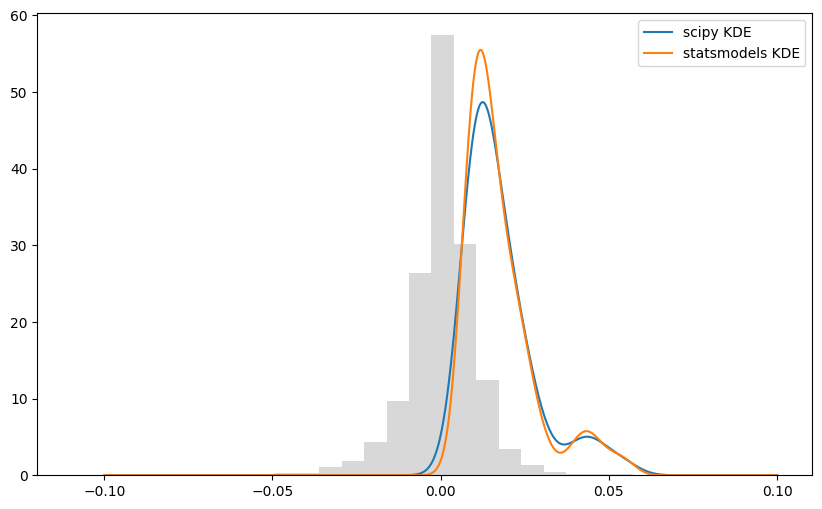

In [107]:
## G3 PDF

x, g3_kde, g3_kde_sm = state_kde_function_vals['g3']
plt.figure(figsize=(10, 6))
plt.plot(x, g3_kde, label='scipy KDE')
plt.plot(x, g3_kde_sm, label='statsmodels KDE')
plt.hist(data['return'], bins=30, density=True, alpha=0.3, color='gray')


plt.legend()
plt.show()

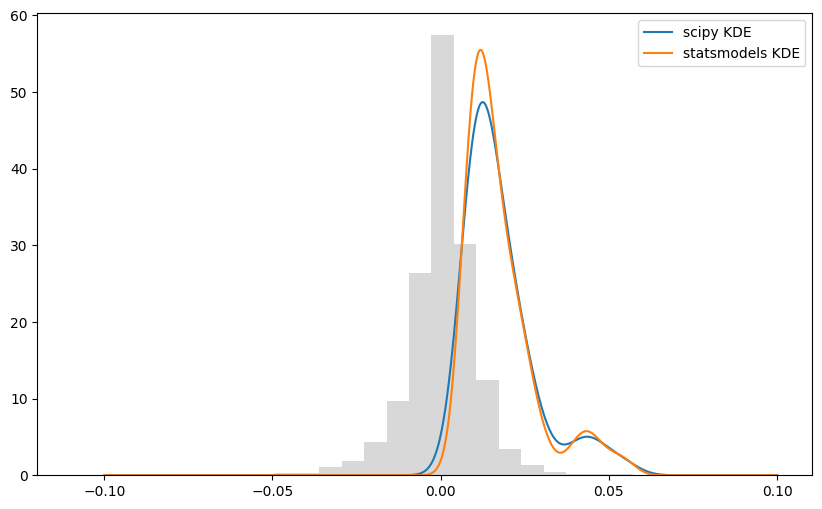

In [108]:
## G1 PDF
x, g1_kde, g1_kde_sm = state_kde_function_vals['g1']
plt.figure(figsize=(10, 6))
plt.plot(x, g3_kde, label='scipy KDE')
plt.plot(x, g3_kde_sm, label='statsmodels KDE')
plt.hist(data['return'], bins=30, density=True, alpha=0.3, color='gray')

plt.legend()
plt.show()

In [109]:
# Graphs of g1, g3 looked dangerously close, just verifying there was no code issue that they are exactly the same.
x, vals1, _ = state_kde_function_vals['g1']
x, vals3, _ = state_kde_function_vals['g3']
vals1[550:] - vals3[550:]

array([-2.50503949e+01, -2.64323397e+01, -2.77491035e+01, -2.89986155e+01,
       -3.01771695e+01, -3.12811142e+01, -3.23083311e+01, -3.32591686e+01,
       -3.41365956e+01, -3.49455239e+01, -3.56914712e+01, -3.63789462e+01,
       -3.70100453e+01, -3.75837299e+01, -3.80960751e+01, -3.85415034e+01,
       -3.89147183e+01, -3.92128202e+01, -3.94370054e+01, -3.95933446e+01,
       -3.96923802e+01, -3.97476059e+01, -3.97731893e+01, -3.97814962e+01,
       -3.97810010e+01, -3.97750424e+01, -3.97616369e+01, -3.97342870e+01,
       -3.96834916e+01, -3.95985435e+01, -3.94692070e+01, -3.92869883e+01,
       -3.90458788e+01, -3.87426235e+01, -3.83766739e+01, -3.79500121e+01,
       -3.74669832e+01, -3.69341731e+01, -3.63602751e+01, -3.57558260e+01,
       -3.51326989e+01, -3.45033051e+01, -3.38795572e+01, -3.32717478e+01,
       -3.26875563e+01, -3.21313933e+01, -3.16042210e+01, -3.11038808e+01,
       -3.06258356e+01, -3.01641535e+01, -2.97125206e+01, -2.92650996e+01,
       -2.88171188e+01, -

In [110]:
kelly_bets_by_state = determine_kelly_bet_by_state(state_kde_functions, possible_states=['g1', 'g2', 'g3'])
kelly_bets_by_state

Success with initial guess 0.6000000000000001:
 message: The solution converged.
 success: True
  status: 1
     fun: 0.0
       x: [ 6.000e-01]
  method: hybr
    nfev: 3
    fjac: [[ 1.000e+00]]
       r: [-0.000e+00]
     qtf: [ 0.000e+00]
The optimal Kelly bet fraction S is: 0.6000000000000001


/var/folders/cj/bm5yf47x4_q7ss8q04sp_hg40000gn/T/ipykernel_22676/491348268.py:63: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  result, error = quad(integrand, minimum_return, maximum_return, limit=10000)
/var/folders/cj/bm5yf47x4_q7ss8q04sp_hg40000gn/T/ipykernel_22676/491348268.py:61: RuntimeWarning: divide by zero encountered in divide
  return return_pdf(x) * x / (1 + S * x)
/var/folders/cj/bm5yf47x4_q7ss8q04sp_hg40000gn/T/ipykernel_22676/491348268.py:63: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(integrand, minimum_return, maximum_return, limit=10000)
/var/folders/cj/bm5yf47x4_q7ss8q04sp_hg40000gn/T/ipykernel_22676/491348268.py:63: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the

Root finding failed: The number of calls to function has reached maxfev = 400.
Root finding failed: The number of calls to function has reached maxfev = 400.


,g1,g2,g3
0,[0.6000000000000001],[1.3193322225481084e+85],[9.018395538482499e+84]
1,None,None,None


In [111]:
kelly_bets_by_state

,g1,g2,g3
0,[0.6000000000000001],[1.3193322225481084e+85],[9.018395538482499e+84]
1,None,None,None
